In [1]:
import matplotlib.pyplot as plt
from multireward_ope.tabular.envs.riverswim import RiverSwim, RiverSwimParameters
from multireward_ope.tabular.envs.env import make_env, DoubleChainParameters, EnvType
from multireward_ope.tabular.policy import Policy, PolicyFactory
from enum import Enum
from multireward_ope.tabular.mdp import MDP
from multireward_ope.tabular.characteristic_time import CharacteristicTimeSolver
from multireward_ope.tabular.reward_set import RewardSetCircle, \
    RewardSetRewardFree, RewardSetPolytope
from typing import NamedTuple
import preamble_figures
from preamble_figures import colors
import lzma
import pickle
import numpy as np
import cvxpy as cp

In [ ]:
# %%time
p_values= np.linspace(0.1, 0.95, 100)
s_values = [5, 20]
gamma = 0.9
results_rfree = {s: [] for s in s_values}
results_circle = {s: [] for s in s_values}

for s in s_values:
    for p in p_values:
        mdp = RiverSwim(RiverSwimParameters(s, p))
        policy = PolicyFactory.from_sequence(np.ones(mdp.dim_state, dtype=np.long))

        # Reward free
        rfree = RewardSetRewardFree(mdp.dim_state, mdp.dim_action, RewardSetRewardFree.RewardSetFreeConfig())
        solver = CharacteristicTimeSolver(mdp.dim_state, mdp.dim_action,solver=cp.CLARABEL)
        solver.build_problem(rfree)

        results_rfree[s].append(solver.solve(0.9, mdp, policy).value)

        # Circle
        rewards = RewardSetCircle(mdp.dim_state, mdp.dim_action,
            RewardSetCircle.RewardSetCircleConfig(np.zeros(mdp.dim_state), radius=1, p=2))
        solver.build_problem(rewards)
        results_circle[s].append(solver.solve(gamma, mdp, policy).value)


with lzma.open('./data/example_riverswim.lzma', 'wb') as f:
    results = {'gamma': gamma, 'circle': results_circle, 'rfree': results_rfree, 'p_values': p_values, 's_values': s_values}
    pickle.dump(results, f)

/project/onlinepe/multi-reward-ope/.venv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/project/onlinepe/multi-reward-ope/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [5]:

s_values = [x for x in range(2,30)]
results_circle = []
results_rfree = []
np.random.seed(0)
gamma = 0.9
for s in s_values:
    mdp = RiverSwim(RiverSwimParameters(s))
    policy = PolicyFactory.from_sequence(np.ones(mdp.dim_state, dtype=np.long))
    rewards = RewardSetCircle(mdp.dim_state, mdp.dim_action,
        RewardSetCircle.RewardSetCircleConfig(np.zeros(mdp.dim_state), radius=1, p=2))
   
    rfree = RewardSetRewardFree(mdp.dim_state, mdp.dim_action, RewardSetRewardFree.RewardSetFreeConfig())
    solver = CharacteristicTimeSolver(mdp.dim_state, mdp.dim_action,solver=cp.CLARABEL)
    solver.build_problem(rewards)
    results_circle.append(solver.solve(gamma, mdp, policy).value)

    solver.build_problem(rfree)
    solution = solver.solve(0.9, mdp, policy)
    results_rfree.append(solution.value)



with lzma.open('./data/example_riverswim_2.lzma', 'wb') as f:
    results = {'gamma': gamma, 'circle': results_circle, 'rfree': results_rfree,'s_values': s_values}
    pickle.dump(results, f)

/project/onlinepe/multi-reward-ope/.venv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


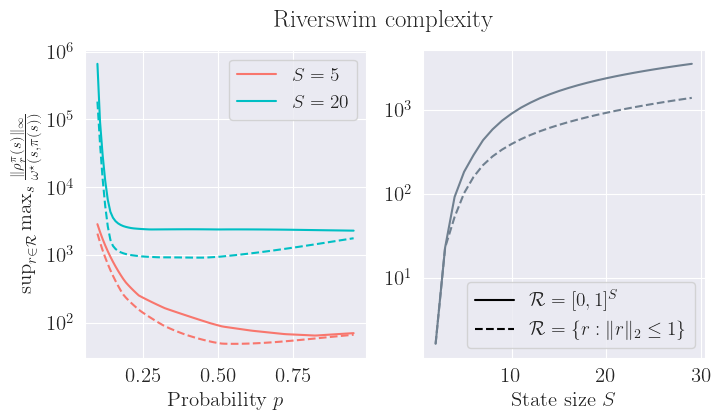

In [46]:
with lzma.open('./data/example_riverswim.lzma', 'rb') as f:
    results = pickle.load(f)
    s_values = results['s_values']
    p_values = results['p_values']
    results_rfree = results['rfree']
    results_circle = results['circle']

with lzma.open('./data/example_riverswim_2.lzma', 'rb') as f:
    results = pickle.load(f)
    s_values2 = results['s_values']
    results_rfree2 = results['rfree']
    results_circle2 = results['circle']

fig,ax = plt.subplots(1,2, figsize=(8,4))
for sid, s in enumerate(s_values):
    ax[0].plot(p_values, np.array(results_rfree[s]), color=colors[sid], label=f'$S={s}$')
    ax[0].plot(p_values, np.array(results_circle[s]), '--', color=colors[sid])
ax[0].legend(fontsize=14)
ax[0].set_xlabel('Probability $p$')
ax[0].set_ylabel(r"$\sup_{r\in {\cal R}}\max_{s} \frac{\|\rho_r^\pi(s)\|_\infty}{\omega^\star(s,\pi(s))}$")
ax[0].set_yscale('log')


ax[1].plot(s_values2, results_rfree2,  color='slategray', label=r"${\cal R}=[0,1]^S$")
ax[1].plot(s_values2, results_circle2, '--', color='slategray', label=r"${\cal R}=\|r\|_2\leq 1$")
ax[1].set_xlabel('State size $S$')
ax[1].set_yscale('log')


from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', linestyle='-'),
                Line2D([0], [0], color='black', linestyle='--')]
ax[1].legend(custom_lines, [r"${\cal R}=[0,1]^S$", r"${\cal R}=\{r:\|r\|_2\leq 1\}$"],fontsize=14)

#ax[1].legend(fontsize=14)

plt.suptitle('Riverswim complexity')

# Show the plot
plt.savefig("figures/riverswim_complexity.pdf", bbox_inches='tight')

/project/onlinepe/multi-reward-ope/.venv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


Text(0, 0.5, 'Characteristic time $T^\\star$')

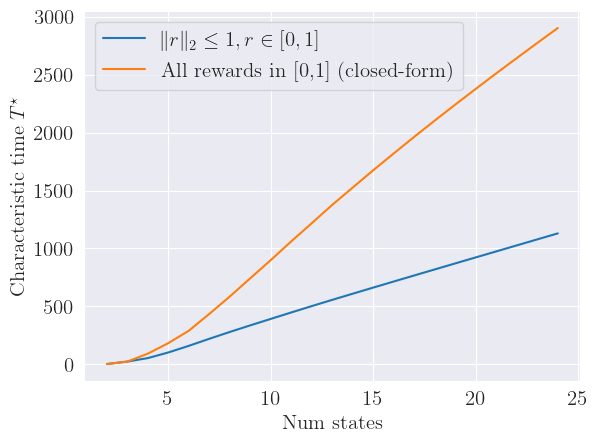

/project/onlinepe/multi-reward-ope/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


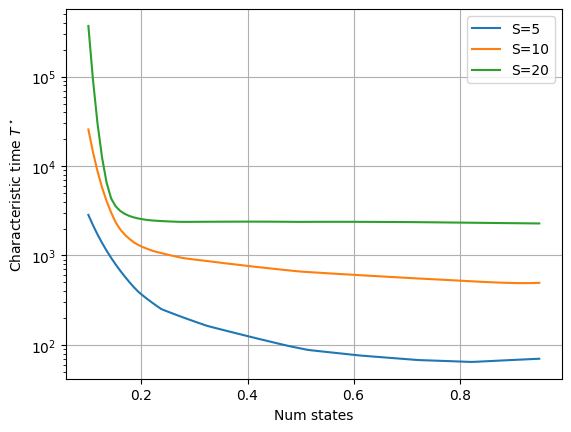